<a href="https://colab.research.google.com/github/fikran03/Kelompok_Boboiboy_Halilintar_NLP_Hewan_Laut/blob/main/HEWAN_LAUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install pymupdf

In [2]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.2 MB/s eta 0:00:00


In [ ]:
pip install transformers

Saving datalaut.pdf to datalaut.pdf
Masukkan pertanyaan Anda: Bagaimana masyarakat lokal Papua berperan dalam konservasi hewan laut?


Some weights of AlbertForQuestionAnswering were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error dengan model indobenchmark: not a string
Menggunakan model alternatif xlm-roberta-base


Some weights of XLMRobertaForQuestionAnswering were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Jawaban yang dihasilkan: program-program konservasi lokal, 
dan menyebarkan kesadaran tentang pentingnya perlindungan
BERTScore Precision: 0.78
BERTScore Recall: 0.71
BERTScore F1: 0.74


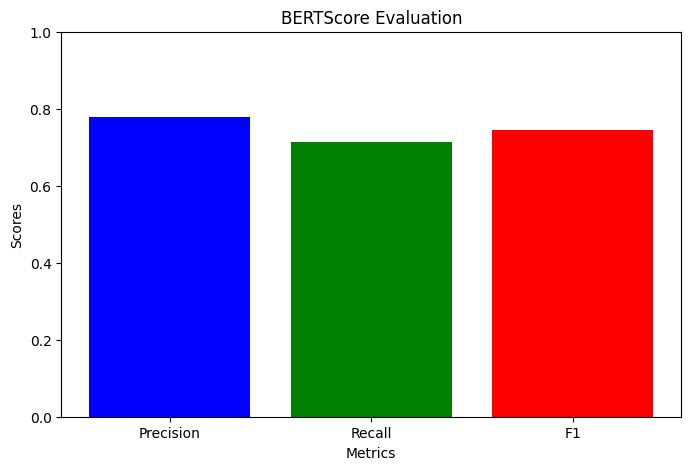

In [23]:
import fitz  # PyMuPDF
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from transformers import pipeline
from bert_score import score
import matplotlib.pyplot as plt

# Fungsi untuk mengekstrak teks dari PDF
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text()
    return text

# Mengunggah file PDF (gunakan metode yang sesuai jika di Colab)
from google.colab import files
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]

# Mengekstrak teks dari PDF
text = extract_text_from_pdf(pdf_path)

# Membagi teks menjadi halaman untuk dimasukkan ke FAISS
pages = [{"page_content": page} for page in text.split("\n\n")]

# Menginisialisasi model sentence-transformers
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Mendapatkan embeddings untuk setiap halaman
embeddings = model.encode([page['page_content'] for page in pages])

# Fungsi untuk melakukan pencarian kesamaan
def similarity_search(query, embeddings, pages, model, top_k=5):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_k_indices = np.argsort(similarities[0])[-top_k:][::-1]
    return [pages[i] for i in top_k_indices]

# Melakukan pencarian kesamaan
query = input("Masukkan pertanyaan Anda: ")
docs = similarity_search(query, embeddings, pages, model)

# Menggabungkan konten yang relevan
content = "\n".join([x["page_content"] for x in docs])

# Menggunakan pipeline QA Hugging Face
try:
    qa_model = pipeline("question-answering", model="indobenchmark/indobert-lite-large-p2", tokenizer="indobenchmark/indobert-lite-large-p2")
except Exception as e:
    print(f"Error dengan model indobenchmark: {e}")
    print("Menggunakan model alternatif xlm-roberta-base")
    qa_model = pipeline("question-answering", model="xlm-roberta-base", tokenizer="xlm-roberta-base")

# Melakukan inferensi
qa_input = {"question": query, "context": content}
result = qa_model(qa_input)
generated_answer = result['answer']

# Menampilkan jawaban yang dihasilkan
print("Jawaban yang dihasilkan:", generated_answer)

# Jawaban referensi (ganti ini dengan jawaban yang benar untuk evaluasi)
reference_answer = "Masyarakat lokal Papua berperan dalam konservasi hewan laut melalui partisipasi dalam program-program konservasi, seperti patroli pantai untuk melindungi sarang penyu, pembuatan kawasan konservasi berbasis masyarakat, dan edukasi tentang pentingnya menjaga keanekaragaman hayati laut."
if reference_answer:
    # Menghitung BERTScore
    P, R, F1 = score([generated_answer], [reference_answer], lang="id")

    # Menyederhanakan output menjadi dua tempat desimal
    P_mean = P.mean().item()
    R_mean = R.mean().item()
    F1_mean = F1.mean().item()

    print(f"BERTScore Precision: {P_mean:.2f}")
    print(f"BERTScore Recall: {R_mean:.2f}")
    print(f"BERTScore F1: {F1_mean:.2f}")

    # Plot hasil BERTScore
    scores = [P_mean, R_mean, F1_mean]
    labels = ['Precision', 'Recall', 'F1']

    plt.figure(figsize=(8, 5))
    plt.bar(labels, scores, color=['blue', 'green', 'red'])
    plt.ylim(0, 1)
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title('BERTScore Evaluation')
    plt.show()
else:
    print("Tidak ada jawaban referensi yang dimasukkan. Evaluasi BERTScore tidak dilakukan.")
